In [1]:
import pandas
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0

2022-01-14 22:23:03.816822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 22:23:03.816840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
directory = os.path.join("Dataset", "Own_Created_Big_Dataset")
train_dir = os.path.join(directory, "train")
validation_dir = os.path.join(directory, "validation")
test_dir = os.path.join(directory, "test")

In [3]:
batch_size = 32
image_size = (224, 224)
NUM_OF_CLASSES = 2

# Input size
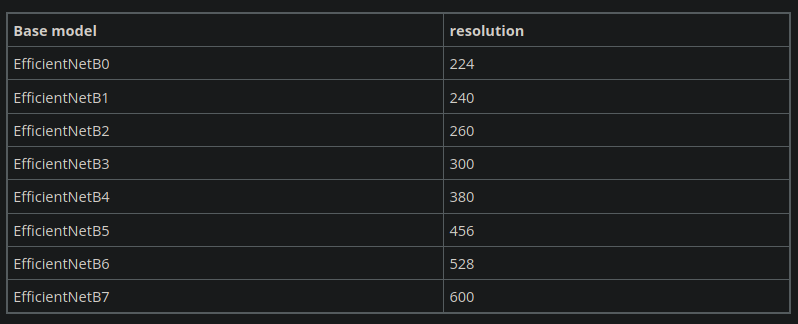

# Reading the images form disk

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                       validation_split = None,
                                                       subset = None,
                                                       seed = 666,
                                                       image_size = image_size,
                                                       batch_size = batch_size)

Found 2519 files belonging to 2 classes.


2022-01-14 22:23:04.829458: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-14 22:23:04.829479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pixel-p): /proc/driver/nvidia/version does not exist
2022-01-14 22:23:04.829705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
validation_ds = tf.keras.utils.image_dataset_from_directory(directory = validation_dir,
                                                       validation_split = None,
                                                       subset = None,
                                                       seed = 666,
                                                       image_size = image_size,
                                                       batch_size = batch_size)

Found 380 files belonging to 2 classes.


In [6]:
# test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
#                                                        validation_split = None,
#                                                        subset = None,
#                                                        seed = 666,
#                                                        image_size = image_size,
#                                                        batch_size = batch_size)

In [7]:
assert train_ds.class_names == validation_ds.class_names #== test_ds.class_names

# Preprocessing + Augmentation

In [8]:
augmentation = Sequential([layers.RandomFlip(),
                           layers.RandomRotation(0.2),
                           layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2)),
                           layers.RandomContrast(factor=0.25)], name="data_augmentation")

In [9]:
train_ds = train_ds.map(lambda x, y:(augmentation(x) , y))

In [10]:
normalize_img = layers.Rescaling(1.0/255)
train_ds = train_ds.map(lambda x, y:(normalize_img(x) , y))

validation_ds = validation_ds.map(lambda x, y:(normalize_img(x) , y))

# test_ds = test_ds.map(lambda x, y:(normalize_img(x) , y))

In [11]:
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, 
                                                      size = (image_size[0], image_size[0]), 
                                                      method='bilinear'), y))

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, 
                                                      size = (image_size[0], image_size[0]), 
                                                      method='bilinear'), y))

# test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, 
#                                                       size = (image_size[0], image_size[0]), 
#                                                       method='bilinear'), y))

# Compute class weights

In [12]:
labels = np.array([])
for i in train_ds.unbatch().as_numpy_iterator():
    labels = np.append(labels, i[1])

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = [0, 1],
                                                 y = labels)
class_weights = {0 : class_weights[0],
                 1 : class_weights[1]}

# Building the model

In [13]:
# from keras.callbacks import ReduceLROnPlateau
# lrr = ReduceLROnPlateau(monitor='val_accuracy', 
#                         factor=0.1, 
#                         patience=2, 
#                         min_lr=0)
lr =  1e-3
opt = tf.keras.optimizers.Adam(learning_rate = lr, 
                               amsgrad = True)
cd = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate = lr)
scheduler_1 = tf.keras.callbacks.LearningRateScheduler(cd)



In [14]:

base_model = EfficientNetB0(include_top = False, 
                            weights = "imagenet", 
                            classes = NUM_OF_CLASSES,
                            input_shape = (image_size[0], image_size[1], 3))

base_model.trainable = False
base_model_out = base_model.output

for layer in base_model.layers:
    layer.trainable = False

flatten_1 = layers.Flatten()(base_model_out)

dropout_2 = layers.Dropout(rate = 0.1)(flatten_1)
hidden_1 = layers.Dense(units=5000, activation='relu')(dropout_2)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(hidden_1)


model = tf.keras.Model(base_model.inputs, outputs)

model.compile(optimizer = opt, 
              loss = "binary_crossentropy",
              weighted_metrics= ["accuracy"])

2022-01-14 22:23:24.146865: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1254400000 exceeds 10% of free system memory.
2022-01-14 22:23:24.404440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1254400000 exceeds 10% of free system memory.
2022-01-14 22:23:24.567282: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1254400000 exceeds 10% of free system memory.


In [15]:
# for layer in model.layers:
#     if isinstance(layer, layers.BatchNormalization) == True:
#         layer.trainable = True

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [17]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(666).prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().shuffle(666).prefetch(buffer_size=AUTOTUNE)

In [18]:
epochs = 5
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs, callbacks = [scheduler_1])

Epoch 1/5


2022-01-14 22:23:26.159607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1254400000 exceeds 10% of free system memory.
2022-01-14 22:23:26.278954: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1254400000 exceeds 10% of free system memory.


79/79 [==============================] - 137s 2s/step - loss: 8.2101 - accuracy: 0.5038 - val_loss: 1.2448 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
79/79 [==============================] - 131s 2s/step - loss: 1.2958 - accuracy: 0.5177 - val_loss: 0.7385 - val_accuracy: 0.5000 - lr: 9.9999e-04
Epoch 3/5
79/79 [==============================] - 133s 2s/step - loss: 1.2594 - accuracy: 0.5312 - val_loss: 0.7179 - val_accuracy: 0.5000 - lr: 9.9996e-04
Epoch 4/5
79/79 [==============================] - 133s 2s/step - loss: 1.1158 - accuracy: 0.5316 - val_loss: 0.7852 - val_accuracy: 0.5000 - lr: 9.9991e-04
Epoch 5/5
79/79 [==============================] - 132s 2s/step - loss: 1.3236 - accuracy: 0.5272 - val_loss: 1.0886 - val_accuracy: 0.5000 - lr: 9.9984e-04


In [19]:
y_pred = model.predict(test_ds) > 0.5

NameError: name 'test_ds' is not defined

In [ ]:
y_true = []
for i in test_ds.unbatch().as_numpy_iterator():
    y_true.append(i[1])
y_true = np.array(y_true)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)